In [3]:
pip install linearmodels

  Obtaining dependency information for linearmodels from https://files.pythonhosted.org/packages/5e/54/39a20f68c49ec8329db26ef7628a54728f0c4cfb4d7bbae8e87d9f662dce/linearmodels-5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pyhdfe>=0.1 from https://files.pythonhosted.org/packages/2f/51/cb006fbc08c32f161035fb19ca718250eb5f6d0692ea6dcc1e62c3e556a2/pyhdfe-0.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for formulaic>=0.6.5 from https://files.pythonhosted.org/packages/ae/f0/ff275c0009f0037c381c6e3a94049b9792df7d7f437c5ccd0c7aefca5f22/formulaic-0.6.6-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 18.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [72]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels import RandomEffects
from sklearn.preprocessing import MinMaxScaler

In [76]:
panel_data = pd.read_csv('Data/final/Merged_airbnb_and_rental.csv')

panel_data[['price_airbnb', 'density_airbnb', 'price_long_rents']] = panel_data[['price_airbnb', 'density_airbnb', 'price_long_rents']].round(3)

panel_data['index_column'] = panel_data.index

panel_data.drop(panel_data[panel_data['year'] == 2019].index, inplace=True)

panel_data.head()

,borough,count_airbnb,price_airbnb,year,borough_area,density_airbnb,code,count_long_rents,price_long_rents,index_column
33,Barking and Dagenham,405,66.331,2020,3.610781e+07,1.122,1,580,1221.638,33
34,Barnet,1643,84.341,2020,8.674831e+07,1.894,2,1580,1470.259,34
35,Bexley,273,59.234,2020,6.058023e+07,0.451,3,850,1135.859,35
36,Brent,2338,94.346,2020,4.323264e+07,5.408,4,1280,1485.523,36
37,Bromley,579,70.786,2020,1.501349e+08,0.386,5,1900,1334.216,37


In [77]:
panel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 33 to 164
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   borough           132 non-null    object 
 1   count_airbnb      132 non-null    int64  
 2   price_airbnb      132 non-null    float64
 3   year              132 non-null    int64  
 4   borough_area      132 non-null    float64
 5   density_airbnb    132 non-null    float64
 6   code              132 non-null    int64  
 7   count_long_rents  132 non-null    int64  
 8   price_long_rents  132 non-null    float64
 9   index_column      132 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 10.4+ KB


In [78]:
panel_data = panel_data.set_index(["year", "code"])

In [81]:
# 选择自变量和因变量

independent_vars = [
    "price_airbnb",
    "density_airbnb",
]
dependent_var = "price_long_rents"  # 之前计算的综合指数

# 准备模型的因变量和自变量
Y = panel_data[dependent_var]
X = panel_data[independent_vars]

# 添加常数项
X = sm.add_constant(X)

In [82]:
# 构建随机效应模型
model = RandomEffects(Y, X)
results = model.fit()

# 输出模型结果
print(results)

                        RandomEffects Estimation Summary                        
Dep. Variable:       price_long_rents   R-squared:                        0.8556
Estimator:              RandomEffects   R-squared (Between):              0.8231
No. Observations:                 132   R-squared (Within):               0.8569
Date:                Sat, Dec 09 2023   R-squared (Overall):              0.8556
Time:                        21:46:26   Log-likelihood                   -854.66
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      382.07
Entities:                           4   P-value                           0.0000
Avg Obs:                       33.000   Distribution:                   F(2,129)
Min Obs:                       33.000                                           
Max Obs:                       33.000   F-statistic (robust):             382.07
                            

In [39]:
from linearmodels.panel import PanelOLS

# 估计固定效应模型
model = PanelOLS(Y, X, entity_effects=True)
results = model.fit()

# 输出固定效应模型的结果
print(results)


                          PanelOLS Estimation Summary                           
Dep. Variable:       price_long_rents   R-squared:                        0.8588
Estimator:                   PanelOLS   R-squared (Between):              0.7408
No. Observations:                 165   R-squared (Within):               0.8588
Date:                Sat, Dec 09 2023   R-squared (Overall):              0.8549
Time:                        17:41:20   Log-likelihood                   -1067.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      480.65
Entities:                           5   P-value                           0.0000
Avg Obs:                       33.000   Distribution:                   F(2,158)
Min Obs:                       33.000                                           
Max Obs:                       33.000   F-statistic (robust):             480.65
                            

In [90]:
panel_data_diff = panel_data['price_airbnb'].diff().dropna()

In [53]:
panel_data.head()

borough  price_long_rents  count_long_rents  year  \
index code                                                                   
2023  1     Barking and Dagenham       1350.025316               790  2023   
      2                   Barnet       1701.178082              2190  2023   
      3                   Bexley       1399.245283               530  2023   
      4                    Brent       1628.101695               590  2023   
      5                  Bromley       1499.208696              2300  2023   

            price_airbnb  borough_area  count_airbnb  density_airbnb  
index code                                                            
2023  1       245.840426      36107810           564        1.561989  
      2       160.523344      86748314          2249        2.592558  
      3        95.046465      60580233           495        0.817098  
      4       179.079197      43232640          2740        6.337804  
      5       105.972798     150134858           772        0.514204

In [83]:
from statsmodels.tsa.stattools import adfuller

# 进行 ADF 单位根检验
#result = adfuller(panel_data['price_long_rents'])
result = adfuller(panel_data['price_airbnb'])
#result = adfuller(panel_data['density_airbnb'])

# 输出 ADF 检验的结果
print('ADF单位根检验结果:')
print(f'ADF统计量: {result[0]}')
print(f'P值: {result[1]}')
print(f'滞后阶数: {result[2]}')
print(f'观察值个数: {result[3]}')
print(f'临界值: {result[4]}')
print(f'1%显著性水平的临界值: {result[4]["1%"]}')
print(f'5%显著性水平的临界值: {result[4]["5%"]}')
print(f'10%显著性水平的临界值: {result[4]["10%"]}')


ADF单位根检验结果:
ADF统计量: -1.0477720323697837
P值: 0.7354444700015154
滞后阶数: 12
观察值个数: 119
临界值: {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
1%显著性水平的临界值: -3.4865346059036564
5%显著性水平的临界值: -2.8861509858476264
10%显著性水平的临界值: -2.579896092790057


In [56]:
from statsmodels.tsa.stattools import coint

# 进行协整关系检验
result = coint(panel_data['density_airbnb'], panel_data['price_airbnb'])

# 输出协整关系检验的结果
print('协整关系检验结果:')
print(f'Cointegration statistic: {result[0]}')
print(f'P-value: {result[1]}')
print(f'Critical values: {result[2]}')


协整关系检验结果:
Cointegration statistic: -1.732269462217077
P-value: 0.6620000668993676
Critical values: [-3.96446642 -3.37364039 -3.07041211]


In [57]:
#BP检验
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan

# 估计随机效应模型
model = sm.OLS(Y, X)
results = model.fit()

# 进行Breusch-Pagan检验
bp_test = het_breuschpagan(results.resid, X)

# 输出检验结果
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(lzip(labels, bp_test))


[('LM Statistic', 13.9357191946653), ('LM-Test p-value', 0.0009416662953856458), ('F-Statistic', 7.472271067324518), ('F-Test p-value', 0.0007868741882286428)]


In [58]:
#Hausman检验
from scipy.stats import chi2

model_fe = PanelOLS(Y, X, entity_effects=True).fit()
model_re = RandomEffects(Y, X).fit()

# Calculate the difference in coefficients
coeff_diff = model_fe.params - model_re.params

# Calculate the variance-covariance matrix of the difference
vcov_diff = model_fe.cov - model_re.cov

# Calculate the Hausman test statistic
hausman_statistic = coeff_diff @ np.linalg.inv(vcov_diff) @ coeff_diff

# Calculate degrees of freedom
df = len(coeff_diff)

# Calculate p-value using chi-square distribution
p_value = 1 - chi2.cdf(hausman_statistic, df)

# Output Hausman test result
print(f'Hausman Statistic: {hausman_statistic}')
print(f'Degrees of Freedom: {df}')
print(f'P-value: {p_value}')

Hausman Statistic: 1.2150230550721566
Degrees of Freedom: 3
P-value: 0.7494034635595925


year  code
2020  1        33
      2        34
      3        35
      4        36
      5        37
             ... 
2023  29      160
      30      161
      31      162
      32      163
      33      164
Name: index_column, Length: 132, dtype: int64
<bound method PanelResults.predict of                         RandomEffects Estimation Summary                        
Dep. Variable:       price_long_rents   R-squared:                        0.8556
Estimator:              RandomEffects   R-squared (Between):              0.8231
No. Observations:                 132   R-squared (Within):               0.8569
Date:                Sat, Dec 09 2023   R-squared (Overall):              0.8556
Time:                        21:46:26   Log-likelihood                   -854.66
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      382.07
Entities:                           4   P-value            

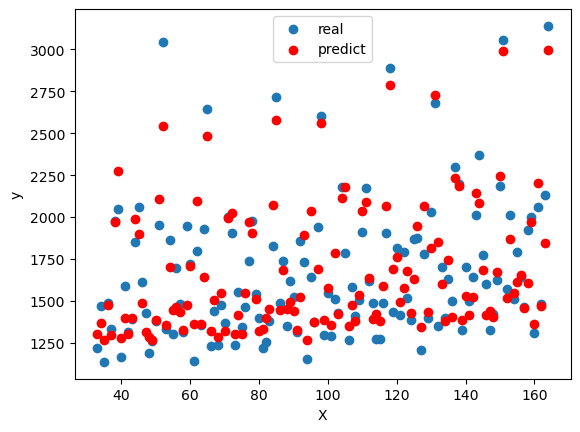

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd

# # 创建一些示例数据
# np.random.seed(42)
# data = {'X1': np.random.rand(100),
#         'X2': np.random.rand(100),
#         'random_effect': np.random.normal(0, 2, size=100),
#         'y': 2 * np.random.rand(100) + 0.5 * np.random.rand(100) + 1 + np.random.randn(100) * 2}
# df = pd.DataFrame(data)

# # 构建多元随机效应模型
# model = sm.MixedLM.from_formula("y ~ X1 + X2", groups=df["random_effect"], data=df)
# result = model.fit()

print(panel_data['index_column'])
print(results.predict)
# 画图
plt.scatter(panel_data['index_column'], Y, label='real')  # 散点图表示真实值
plt.scatter(panel_data['index_column'], results.predict(X), color='red', label='predict')  # 散点图表示模型结果
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
